### Analyze Prizer & Roche with statsmodels
- seasonal decompose
- seasonal is stationary
- adfuller Time Series is Non-Stationary
- ExponentialSmoothing prediction

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df1 = pd.read_csv('/home/becode/Desktop/Time Series/venv/scr/data/yfin_AdjClose.csv', index_col='Date', parse_dates = ['Date'])
df1 = df1[df1.index > '01-01-2015']

In [2]:
# Group  & Filter data for values above 0
df_agg = df1.groupby('Date')[['PFE','RHHVF']].sum()
y = df_agg[(df_agg['PFE']>0) & (df_agg['RHHVF']>0)]
y = y.resample('M').sum()

Observe if there is seasonality in the datasets for Pfizer

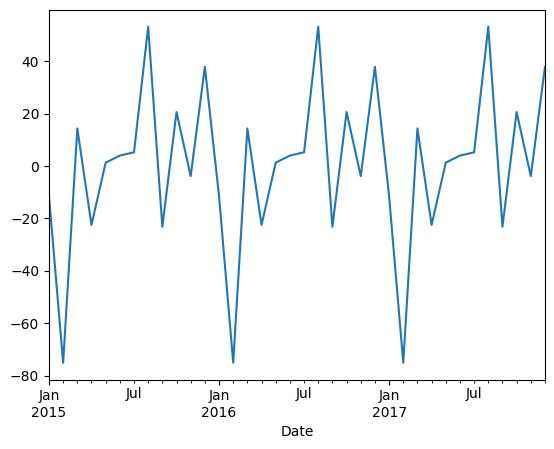

In [3]:
decomposition = sm.tsa.seasonal_decompose(y['PFE'])
decomposition.seasonal["2015":"2017"].plot();

In [4]:
#res = adfuller(y.iloc[:,0])
res = adfuller(y.iloc[:,1])
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
if res[0] < res[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")    

Augmneted Dickey_fuller Statistic: -1.627115
p-value: 0.469001
critical values at different levels:
	1%: -3.507
	5%: -2.895
	10%: -2.585
Failed to Reject Ho - Time Series is Non-Stationary


# Compare Pfizer & Roche

### The inputs for the Sharpe Ratio: Starting with Monthy Stock Returns<br>

The Sharpe Ratio uses the difference in returns between the two investment opportunities 

count    98.000000
mean      0.008334
std       0.111284
min      -0.311389
25%      -0.062680
50%       0.005969
75%       0.084201
max       0.257663
Name: PFE, dtype: float64

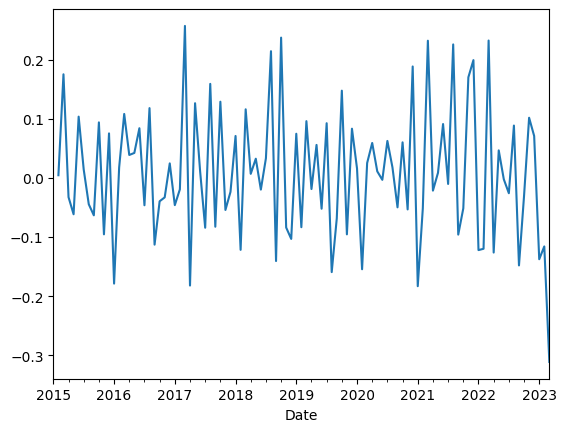

In [5]:
# calculate daily stock_data returns 	
stock_returns = y.loc[:,'PFE'].pct_change()

# plot the daily returns
stock_returns.plot()

# summarize the daily returns
stock_returns.describe()

count    98.000000
mean      0.004242
std       0.104527
min      -0.297250
25%      -0.071302
50%      -0.010636
75%       0.072044
max       0.307253
Name: RHHVF, dtype: float64

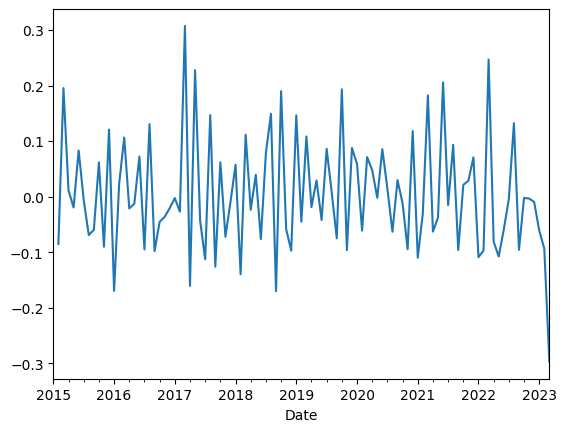

In [6]:
# calculate daily benchmark_data returns
sp_returns = y.loc[:,'RHHVF'].pct_change()

# plot the daily returns
sp_returns.plot()

# summarize the daily returns
sp_returns.describe()


## Other approaches to analyze

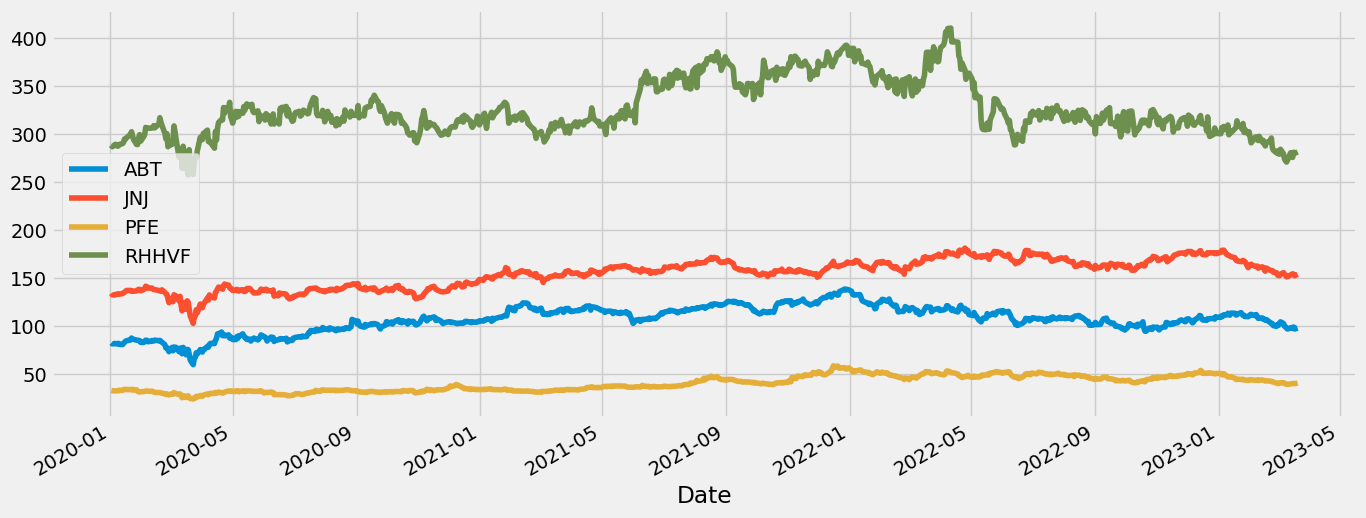

In [7]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
class CFG:
   img_dim1 = 15
   img_dim2 = 6   
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   
df = pd.read_csv('/home/becode/Desktop/Time Series/venv/scr/data/yfin_AdjClose.csv')
df = df[df['Date'] > '2020-01-01']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.plot()
plt.show()

In [8]:
df.index.duplicated().sum() == 0, df.index

(True,
 DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
                '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
                '2020-01-14', '2020-01-15',
                ...
                '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
                '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
                '2023-03-17', '2023-03-20'],
               dtype='datetime64[ns]', name='Date', length=809, freq=None))

In [9]:
df.head()

,ABT,JNJ,PFE,RHHVF
Date,,,,
2020-01-02,82.532562,134.100250,32.951439,288.181763
2020-01-03,81.526421,132.547714,32.774654,286.503723
2020-01-06,81.953560,132.382309,32.732552,289.109131
2020-01-07,81.497940,133.190720,32.623108,287.881470
2020-01-08,81.830162,133.172424,32.884094,287.069000


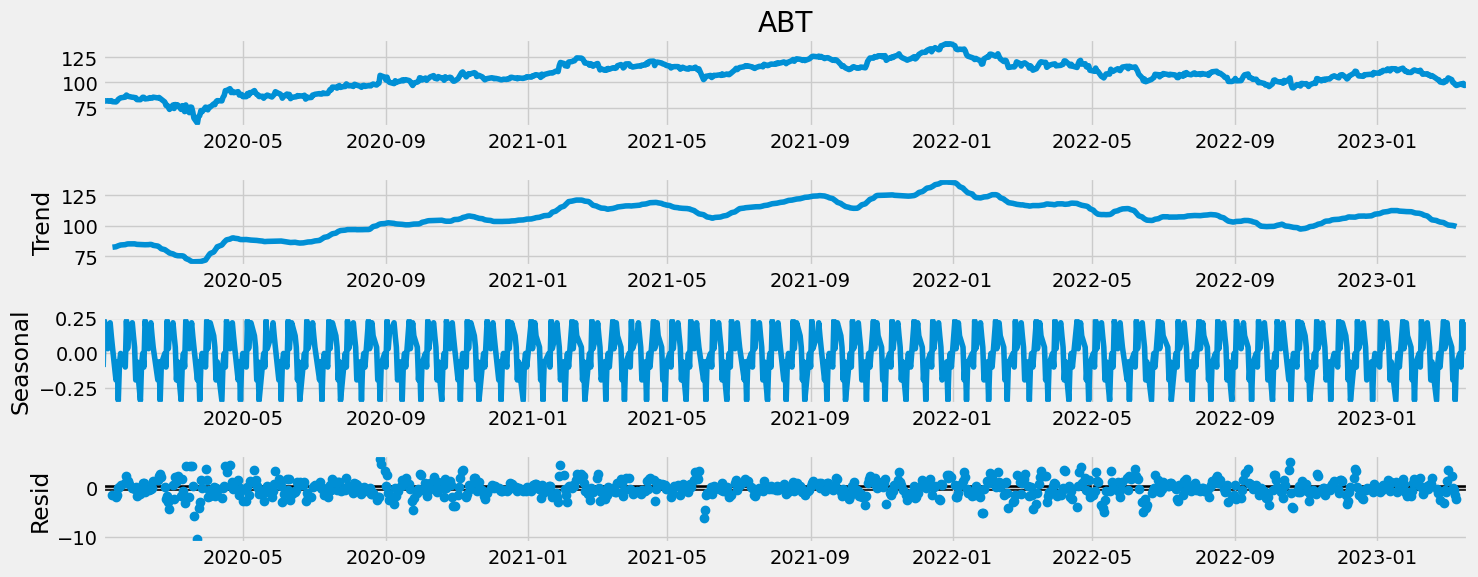

In [10]:
y = df[(df['ABT']>0) & (df['RHHVF']>0)]
decomposition = seasonal_decompose(y.iloc[:,0], period = 12)
figure = decomposition.plot()
plt.show()

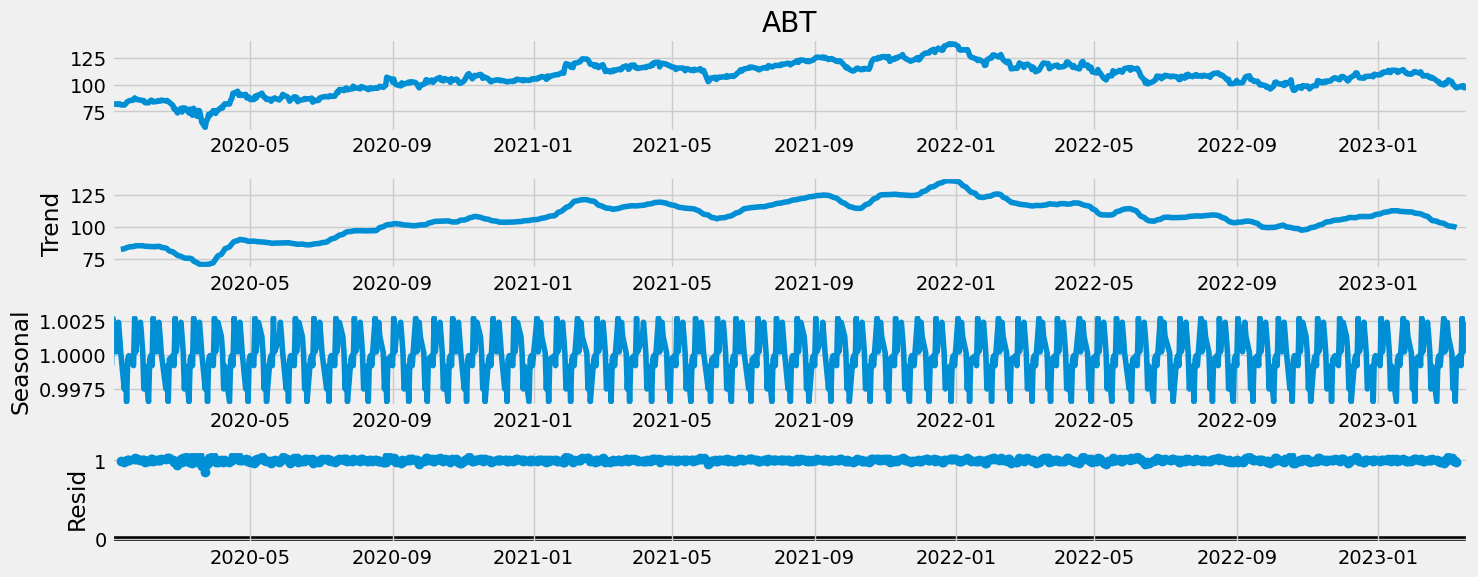

In [11]:
decomposition = seasonal_decompose(y.iloc[:,0], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

Explore Roche Autocorrelation

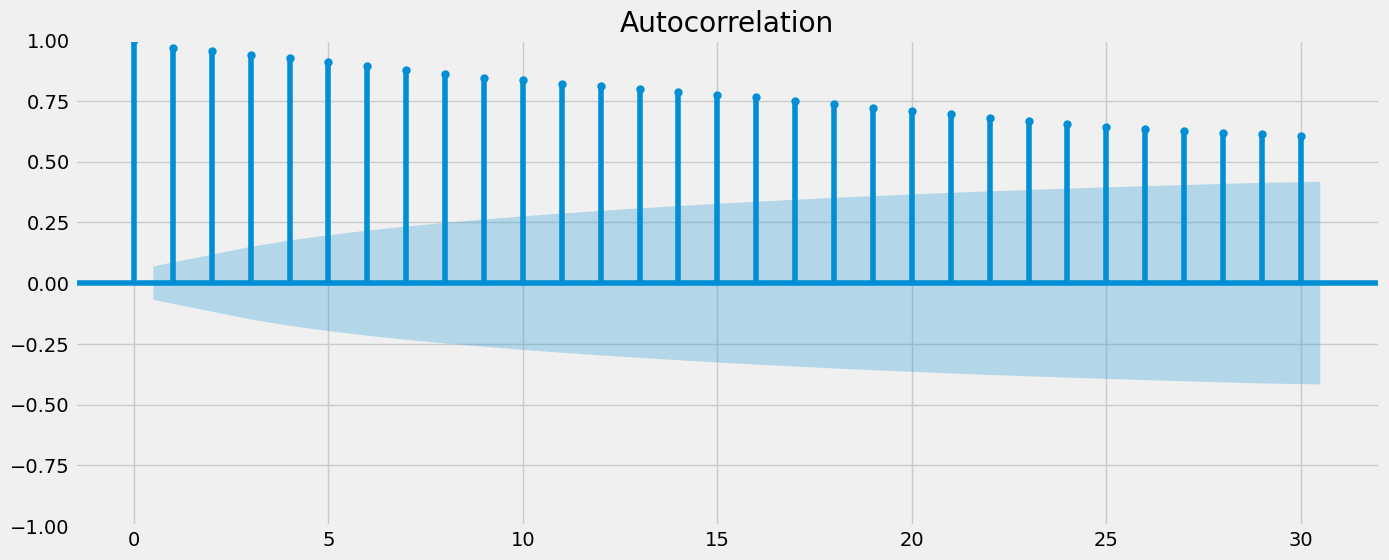

In [12]:

plot_acf(y.iloc[:,3])
print()

Explore Partial Autocorrelation for Roche

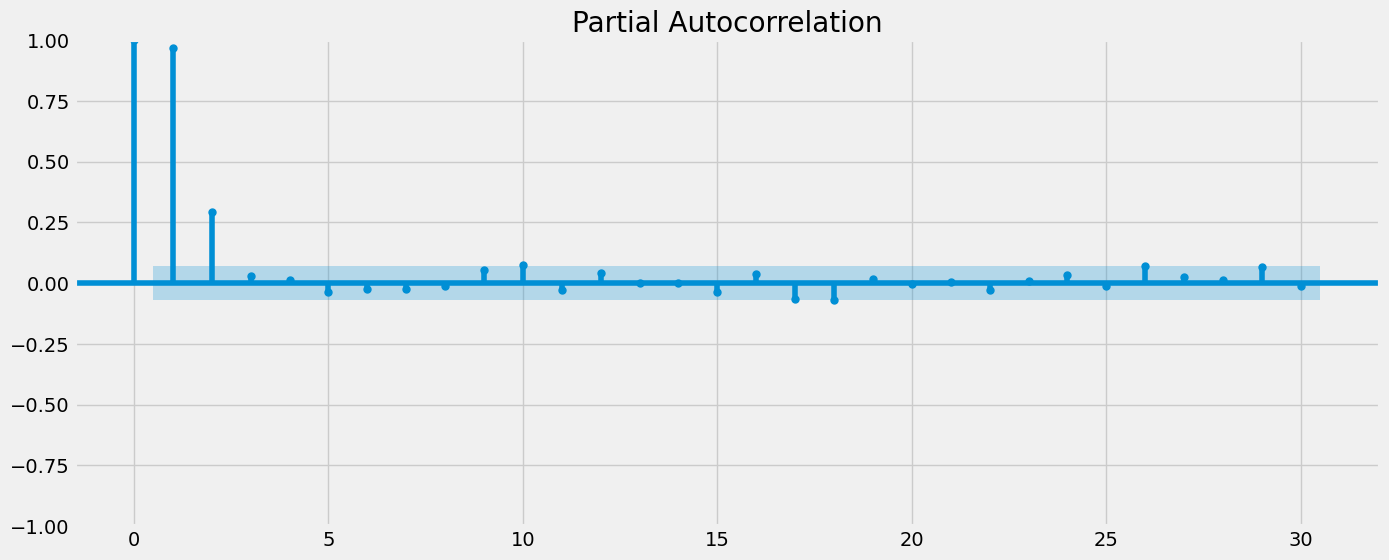

In [13]:
plot_pacf(y.iloc[:,3], method='ywm')
print()

## Smoothing methods for prediction in ABT stocks

In [14]:
# training / validation split
df = pd.read_csv('/home/becode/Desktop/Time Series/venv/scr/data/yfin_AdjClose.csv')
df = df[df['Date'] > '2021-01-01']
#df = df[df['Date'] > '2017-01-01']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
y = df[(df['ABT']>0) & (df['RHHVF']>0)]
cutoff_date = '2022-09-1'
#cutoff_date = '2019-12-1'
xtrain, xvalid  = y.loc[y.index <= cutoff_date], y.loc[y.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(420, 4) (136, 4)


In [15]:
fit1 = ExponentialSmoothing(xtrain['ABT'].values, seasonal_periods = 12, 
                            trend = 'mul', seasonal = 'mul', initialization_method="estimated")

fit1 = fit1.fit()

In [16]:
prediction = fit1.forecast(len(xvalid)).copy()
xresiduals = xvalid['ABT'] - prediction

In [17]:
fcast3 = fit1.forecast(3)
fcast3

array([104.12800068, 104.07436515, 104.40922369])

In [18]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,9.999976e-01,True
smoothing_trend,beta,1.470841e-12,True
smoothing_seasonal,gamma,1.532115e-09,True
initial_level,l.0,9.134261e+01,True
initial_trend,b.0,9.998762e-01,True
initial_seasons.0,s.0,1.151819e+00,True
initial_seasons.1,s.1,1.151368e+00,True
initial_seasons.2,s.2,1.155216e+00,True
initial_seasons.3,s.3,1.153108e+00,True
initial_seasons.4,s.4,1.150695e+00,True


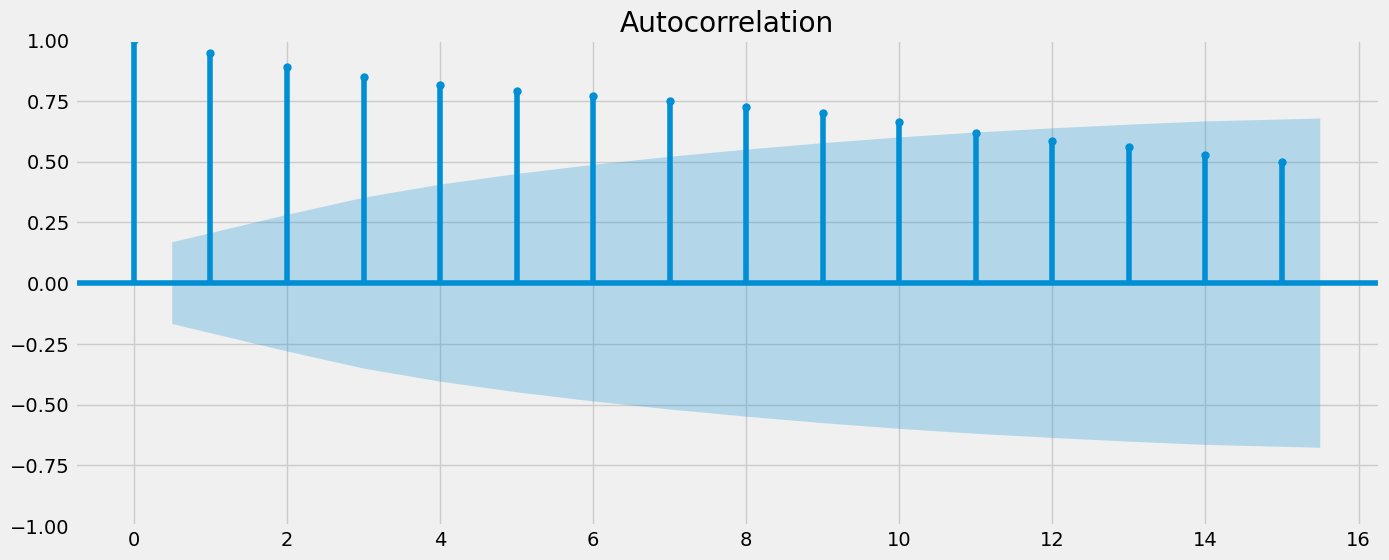

In [19]:
plot_acf(xresiduals, lags = 15)
print()

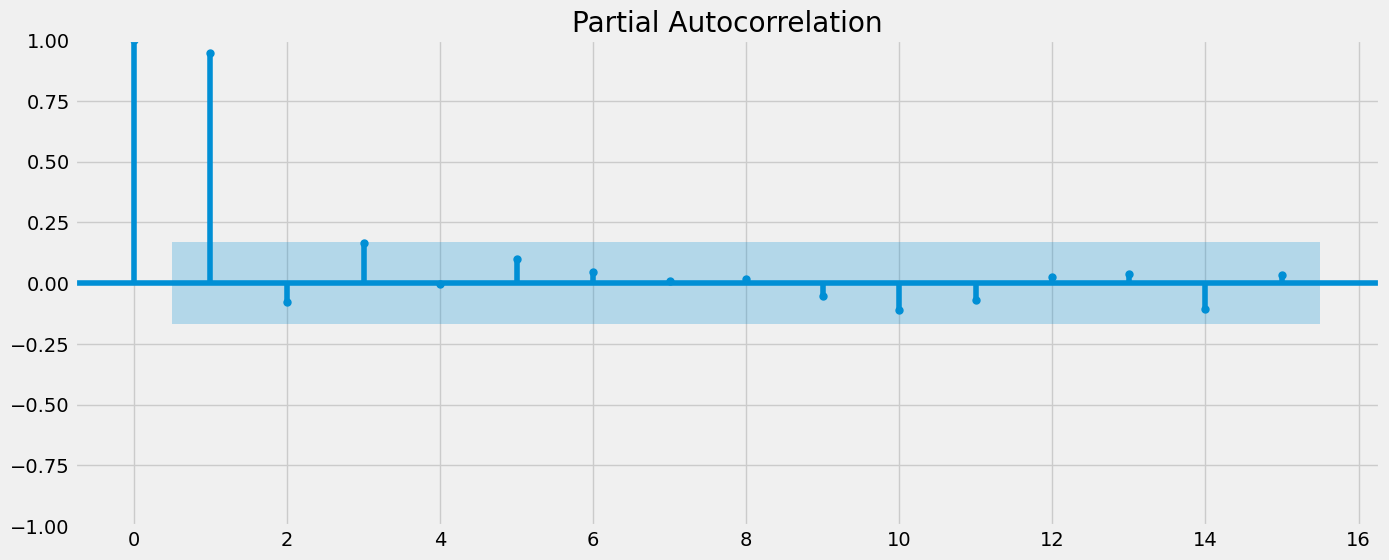

In [20]:
plot_pacf(xresiduals, lags = 15, method='ywm')
print()